In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [35]:
y_test = y_test - 769
y_train_valid = y_train_valid - 769
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [36]:
# For subject 1
'''
X_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]
y_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]
X_test_1 = X_test[np.where(person_test==0)[0]]
y_test_1 = y_test[np.where(person_test==0)[0]]
'''

'\nX_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]\ny_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]\nX_test_1 = X_test[np.where(person_test==0)[0]]\ny_test_1 = y_test[np.where(person_test==0)[0]]\n'

In [37]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                              test_size=0.2,shuffle=True)

train_set = Dataset(X_train,y_train)
val_set = Dataset(X_valid,y_valid)
test_set = Dataset(X_test, y_test)
print(X_train.shape)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=43,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=15,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=12,shuffle=True)

(1692, 22, 1000)


In [39]:
#目前这个最好
#只有FC有dropout
# [conv-relu]*2 -> 2*2 max-pooling -> [conv-relu]*3 -> 2*2 max_pooling -> (affine-relu)*2 -> affine -> softmax
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  # initial the model
        self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
        self.bn1 = nn.BatchNorm1d(40)
        self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
        self.bn2 = nn.BatchNorm1d(60) 
        self.pool1 = nn.MaxPool1d(2,2) 
        
        self.conv3 = nn.Conv1d(60,80,kernel_size = 3, stride = 1) 
        self.bn3 = nn.BatchNorm1d(80)
        self.conv4 = nn.Conv1d(80,100,kernel_size = 3, stride = 1) 
        self.bn4 = nn.BatchNorm1d(100)
        self.conv5 = nn.Conv1d(100,120,kernel_size = 3, stride = 2) #120*122
        self.bn5 = nn.BatchNorm1d(120)
        self.pool2 = nn.MaxPool1d(2,2) #120*61
        
        self.fc1 = nn.Linear(120*61, 300) # input dim , output dim
        self.bn6 = nn.BatchNorm1d(300)
        self.drop1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(300,40)  
        self.bn7 = nn.BatchNorm1d(40)
        self.drop2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(40,4)
 
    def forward(self,x):
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1,120*61)
        
        x = self.drop1(F.relu(self.bn6(self.fc1(x))))
        x = self.drop2(F.relu(self.bn7(self.fc2(x))))
        x = self.fc3(x)
        return x
net = Net()
print(net)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)

Net(
  (conv1): Conv1d(22, 40, kernel_size=(2,), stride=(2,))
  (bn1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(40, 60, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(60, 80, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(80, 100, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(100, 120, kernel_size=(3,), stride=(2,))
  (bn5): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7320, out_features=300, bias=True)
  (bn6): BatchNorm1d(300,

Epoch 0 | Iter1 | Loss1.9919 | TrainAcc0.0930 | val acc 0.2009
Epoch 0 | Iter3 | Loss1.6729 | TrainAcc0.1860 | val acc 0.2600
Epoch 0 | Iter5 | Loss1.6541 | TrainAcc0.1628 | val acc 0.2388
Epoch 0 | Iter7 | Loss1.4611 | TrainAcc0.3488 | val acc 0.2813
Epoch 0 | Iter9 | Loss1.6181 | TrainAcc0.1628 | val acc 0.3050
Epoch 0 | Iter11 | Loss1.7692 | TrainAcc0.1628 | val acc 0.2411
Epoch 0 | Iter13 | Loss1.5474 | TrainAcc0.2093 | val acc 0.2766
Epoch 0 | Iter15 | Loss1.6855 | TrainAcc0.2558 | val acc 0.2884
Epoch 0 | Iter17 | Loss1.6633 | TrainAcc0.1163 | val acc 0.2648
Epoch 0 | Iter19 | Loss1.5168 | TrainAcc0.1395 | val acc 0.2577
Epoch 0 | Iter21 | Loss1.6966 | TrainAcc0.2093 | val acc 0.2600
Epoch 0 | Iter23 | Loss1.4779 | TrainAcc0.2326 | val acc 0.2837
Epoch 0 | Iter25 | Loss1.4107 | TrainAcc0.2558 | val acc 0.2955
Epoch 0 | Iter27 | Loss1.5973 | TrainAcc0.3023 | val acc 0.2766
Epoch 0 | Iter29 | Loss1.6599 | TrainAcc0.2326 | val acc 0.2861
Epoch 0 | Iter31 | Loss1.5194 | TrainAcc0.255

Epoch 6 | Iter19 | Loss1.2723 | TrainAcc0.3721 | val acc 0.4255
Epoch 6 | Iter21 | Loss1.2693 | TrainAcc0.4186 | val acc 0.4184
Epoch 6 | Iter23 | Loss1.2603 | TrainAcc0.3953 | val acc 0.4326
Epoch 6 | Iter25 | Loss1.2670 | TrainAcc0.5116 | val acc 0.3853
Epoch 6 | Iter27 | Loss1.2675 | TrainAcc0.3953 | val acc 0.4255
Epoch 6 | Iter29 | Loss1.2889 | TrainAcc0.3488 | val acc 0.4184
Epoch 6 | Iter31 | Loss1.3528 | TrainAcc0.4651 | val acc 0.4208
Epoch 6 | Iter33 | Loss1.3524 | TrainAcc0.3953 | val acc 0.4137
Epoch 6 | Iter35 | Loss1.2672 | TrainAcc0.4884 | val acc 0.4184
Epoch 6 | Iter37 | Loss1.2584 | TrainAcc0.3721 | val acc 0.4255
Epoch 6 | Iter39 | Loss1.1974 | TrainAcc0.4000 | val acc 0.4161
Epoch 7 | Iter1 | Loss1.1803 | TrainAcc0.4651 | val acc 0.4326
Epoch 7 | Iter3 | Loss1.1941 | TrainAcc0.4419 | val acc 0.4090
Epoch 7 | Iter5 | Loss1.2093 | TrainAcc0.4186 | val acc 0.3877
Epoch 7 | Iter7 | Loss1.1759 | TrainAcc0.5116 | val acc 0.4161
Epoch 7 | Iter9 | Loss1.1541 | TrainAcc0.418

Epoch 12 | Iter35 | Loss0.9588 | TrainAcc0.6512 | val acc 0.4681
Epoch 12 | Iter37 | Loss1.0947 | TrainAcc0.4884 | val acc 0.4704
Epoch 12 | Iter39 | Loss1.0281 | TrainAcc0.7333 | val acc 0.4704
Epoch 13 | Iter1 | Loss0.9612 | TrainAcc0.6047 | val acc 0.4563
Epoch 13 | Iter3 | Loss0.9357 | TrainAcc0.6279 | val acc 0.4586
Epoch 13 | Iter5 | Loss1.1393 | TrainAcc0.5581 | val acc 0.4634
Epoch 13 | Iter7 | Loss0.9503 | TrainAcc0.5814 | val acc 0.4539
Epoch 13 | Iter9 | Loss0.9623 | TrainAcc0.6512 | val acc 0.4586
Epoch 13 | Iter11 | Loss1.0225 | TrainAcc0.6047 | val acc 0.3948
Epoch 13 | Iter13 | Loss0.8055 | TrainAcc0.6744 | val acc 0.4208
Epoch 13 | Iter15 | Loss0.9930 | TrainAcc0.5814 | val acc 0.4515
Epoch 13 | Iter17 | Loss0.8852 | TrainAcc0.6279 | val acc 0.4232
Epoch 13 | Iter19 | Loss0.9262 | TrainAcc0.6279 | val acc 0.4634
Epoch 13 | Iter21 | Loss1.0429 | TrainAcc0.5581 | val acc 0.4563
Epoch 13 | Iter23 | Loss1.2567 | TrainAcc0.4186 | val acc 0.4610
Epoch 13 | Iter25 | Loss1.0234

Epoch 19 | Iter9 | Loss0.8057 | TrainAcc0.6279 | val acc 0.4492
Epoch 19 | Iter11 | Loss0.7124 | TrainAcc0.7209 | val acc 0.4444
Epoch 19 | Iter13 | Loss0.8416 | TrainAcc0.6279 | val acc 0.4846
Epoch 19 | Iter15 | Loss0.7403 | TrainAcc0.6744 | val acc 0.4681
Epoch 19 | Iter17 | Loss0.7241 | TrainAcc0.7674 | val acc 0.4846
Epoch 19 | Iter19 | Loss0.6961 | TrainAcc0.6977 | val acc 0.4846
Epoch 19 | Iter21 | Loss0.7358 | TrainAcc0.7674 | val acc 0.4775
Epoch 19 | Iter23 | Loss0.8952 | TrainAcc0.6512 | val acc 0.4870
Epoch 19 | Iter25 | Loss0.8694 | TrainAcc0.6744 | val acc 0.3924
Epoch 19 | Iter27 | Loss0.9044 | TrainAcc0.5814 | val acc 0.4397
Epoch 19 | Iter29 | Loss0.8216 | TrainAcc0.6279 | val acc 0.4586
Epoch 19 | Iter31 | Loss0.7092 | TrainAcc0.6744 | val acc 0.4894
Epoch 19 | Iter33 | Loss0.6350 | TrainAcc0.7209 | val acc 0.4965
Epoch 19 | Iter35 | Loss0.8394 | TrainAcc0.6744 | val acc 0.4917
Epoch 19 | Iter37 | Loss0.7641 | TrainAcc0.6512 | val acc 0.4563
Epoch 19 | Iter39 | Loss0.

Epoch 25 | Iter23 | Loss0.8304 | TrainAcc0.7209 | val acc 0.4610
Epoch 25 | Iter25 | Loss0.6233 | TrainAcc0.7209 | val acc 0.4515
Epoch 25 | Iter27 | Loss0.5521 | TrainAcc0.8372 | val acc 0.4515
Epoch 25 | Iter29 | Loss0.4394 | TrainAcc0.7674 | val acc 0.4444
Epoch 25 | Iter31 | Loss0.5497 | TrainAcc0.7209 | val acc 0.4444
Epoch 25 | Iter33 | Loss0.5283 | TrainAcc0.8140 | val acc 0.4326
Epoch 25 | Iter35 | Loss0.5106 | TrainAcc0.7442 | val acc 0.4232
Epoch 25 | Iter37 | Loss0.5748 | TrainAcc0.8140 | val acc 0.3877
Epoch 25 | Iter39 | Loss0.8438 | TrainAcc0.6667 | val acc 0.4468
Epoch 26 | Iter1 | Loss0.6174 | TrainAcc0.7442 | val acc 0.4515
Epoch 26 | Iter3 | Loss0.7152 | TrainAcc0.6512 | val acc 0.4657
Epoch 26 | Iter5 | Loss0.6068 | TrainAcc0.7674 | val acc 0.4563
Epoch 26 | Iter7 | Loss0.4938 | TrainAcc0.8605 | val acc 0.4468
Epoch 26 | Iter9 | Loss0.7932 | TrainAcc0.6744 | val acc 0.4586
Epoch 26 | Iter11 | Loss0.4744 | TrainAcc0.7209 | val acc 0.4303
Epoch 26 | Iter13 | Loss0.5551

Epoch 31 | Iter37 | Loss0.5132 | TrainAcc0.8140 | val acc 0.4326
Epoch 31 | Iter39 | Loss0.5745 | TrainAcc0.6667 | val acc 0.4586
Epoch 32 | Iter1 | Loss0.4741 | TrainAcc0.7674 | val acc 0.4586
Epoch 32 | Iter3 | Loss0.4699 | TrainAcc0.7907 | val acc 0.4610
Epoch 32 | Iter5 | Loss0.4119 | TrainAcc0.8605 | val acc 0.4704
Epoch 32 | Iter7 | Loss0.5662 | TrainAcc0.7674 | val acc 0.4492
Epoch 32 | Iter9 | Loss0.4505 | TrainAcc0.8140 | val acc 0.4823
Epoch 32 | Iter11 | Loss0.4386 | TrainAcc0.8140 | val acc 0.4799
Epoch 32 | Iter13 | Loss0.5157 | TrainAcc0.7674 | val acc 0.4704
Epoch 32 | Iter15 | Loss0.4845 | TrainAcc0.8605 | val acc 0.4374
Epoch 32 | Iter17 | Loss0.3617 | TrainAcc0.8837 | val acc 0.4184
Epoch 32 | Iter19 | Loss0.5681 | TrainAcc0.7442 | val acc 0.4326
Epoch 32 | Iter21 | Loss0.4080 | TrainAcc0.8372 | val acc 0.4539
Epoch 32 | Iter23 | Loss0.5687 | TrainAcc0.7674 | val acc 0.4563
Epoch 32 | Iter25 | Loss0.7081 | TrainAcc0.8140 | val acc 0.4539
Epoch 32 | Iter27 | Loss0.4702

Epoch 38 | Iter11 | Loss0.3565 | TrainAcc0.8837 | val acc 0.4444
Epoch 38 | Iter13 | Loss0.4126 | TrainAcc0.8605 | val acc 0.4492
Epoch 38 | Iter15 | Loss0.5079 | TrainAcc0.8837 | val acc 0.4681
Epoch 38 | Iter17 | Loss0.4920 | TrainAcc0.7674 | val acc 0.4752
Epoch 38 | Iter19 | Loss0.3581 | TrainAcc0.9070 | val acc 0.4515
Epoch 38 | Iter21 | Loss0.4272 | TrainAcc0.7442 | val acc 0.4586
Epoch 38 | Iter23 | Loss0.4663 | TrainAcc0.8140 | val acc 0.4515
Epoch 38 | Iter25 | Loss0.4619 | TrainAcc0.8140 | val acc 0.4539
Epoch 38 | Iter27 | Loss0.4370 | TrainAcc0.8140 | val acc 0.4610
Epoch 38 | Iter29 | Loss0.4622 | TrainAcc0.7907 | val acc 0.4610
Epoch 38 | Iter31 | Loss0.5280 | TrainAcc0.7907 | val acc 0.4752
Epoch 38 | Iter33 | Loss0.7073 | TrainAcc0.6744 | val acc 0.4492
Epoch 38 | Iter35 | Loss0.6025 | TrainAcc0.7674 | val acc 0.4184
Epoch 38 | Iter37 | Loss0.7894 | TrainAcc0.6512 | val acc 0.4397
Epoch 38 | Iter39 | Loss1.2270 | TrainAcc0.6000 | val acc 0.3641
Epoch 39 | Iter1 | Loss0.

Epoch 44 | Iter25 | Loss0.6303 | TrainAcc0.8605 | val acc 0.4941
Epoch 44 | Iter27 | Loss0.4104 | TrainAcc0.7674 | val acc 0.4917
Epoch 44 | Iter29 | Loss0.4760 | TrainAcc0.8605 | val acc 0.4917
Epoch 44 | Iter31 | Loss0.3939 | TrainAcc0.8837 | val acc 0.4988
Epoch 44 | Iter33 | Loss0.3298 | TrainAcc0.9302 | val acc 0.5083
Epoch 44 | Iter35 | Loss0.5192 | TrainAcc0.7674 | val acc 0.4917
Epoch 44 | Iter37 | Loss0.6391 | TrainAcc0.7209 | val acc 0.5130
Epoch 44 | Iter39 | Loss0.3632 | TrainAcc0.8667 | val acc 0.4681
Epoch 45 | Iter1 | Loss0.3845 | TrainAcc0.8605 | val acc 0.4728
Epoch 45 | Iter3 | Loss0.4658 | TrainAcc0.8140 | val acc 0.4634
Epoch 45 | Iter5 | Loss0.3887 | TrainAcc0.8140 | val acc 0.4823
Epoch 45 | Iter7 | Loss0.2841 | TrainAcc0.9535 | val acc 0.5059
Epoch 45 | Iter9 | Loss0.3636 | TrainAcc0.8605 | val acc 0.4965
Epoch 45 | Iter11 | Loss0.3230 | TrainAcc0.8605 | val acc 0.4870
Epoch 45 | Iter13 | Loss0.8673 | TrainAcc0.6977 | val acc 0.5106
Epoch 45 | Iter15 | Loss0.7052

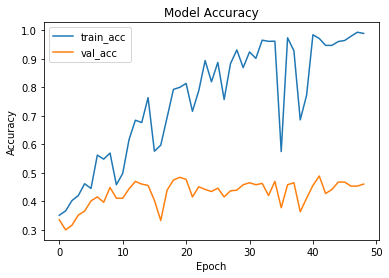

In [40]:
val_acc_history = []
train_acc_history = []
for epoch in range(49):
    for i , data in enumerate(train_loader, 0):
        inputs, labels = data
        
        net.train()
        
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == labels).sum().item() / len(labels)
        
        if i % 2 == 1:
            net.eval()
            val_correct, val_total = 0, 0 
            for val_data in val_loader:
                val_images, val_labels = val_data
                val_outputs = net(val_images)
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
            val_acc = val_correct / val_total
            print('Epoch {} | Iter{} | Loss{:.4f} | TrainAcc{:.4f} | val acc {:.4f}'.format(
                epoch, i , loss, train_acc, val_acc))
            #writer.add_scalar('Train/Loss',loss,epoch*len(trainloader) + i)
            #writer.add_scalar('Train/ACC',train_acc,epoch*len(trainloader) + i)
            #writer.add_scalar('VAL/ACC',val_acc,epoch*len(trainloader) + i)
    net.eval()
    train_correct, train_total = 0, 0
    for train_data in train_loader:
        train_inputs, train_labels = train_data
        train_outputs = net(train_inputs)
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)
    val_correct, val_total = 0, 0
    for val_data in val_loader:
        val_images, val_labels = val_data
        val_outputs = net(val_images)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    #if val_acc == max(val_acc_history):
    #    net_best = Net()
    #    net_best.load_state_dict(net.state_dict())
        
test_correct, test_total = 0, 0
for test_data in test_loader:
    test_images, test_labels = test_data
    test_outputs = net(test_images)
    #test_outputs = net_best(test_images)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)
plt.plot(train_acc_history,)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['train_acc','val_acc'])

In [42]:
net_1 = Net()
net_2 = Net()
net_3 = Net()
net_4 = Net()
net_5 = Net()
net_6 = Net()
net_7 = Net()
list_net = [net_1, net_2, net_3, net_4, net_5, net_6, net_7]
list_best_net = [Net(), Net(), Net(), Net(), Net(), Net(), Net()]
for n,net in enumerate(list_net):
    #val_acc_history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)
    print('--------------------------------------------------')
    print('Training Net {}'.format(n+1))
    for epoch in range(35):
        for i , data in enumerate(train_loader, 0):
            inputs, labels = data
            
            net.train()
            
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i % 2 == 1:
                net.eval()
                val_correct, val_total = 0, 0 
                for val_data in val_loader:
                    val_images, val_labels = val_data
                    val_outputs = net(val_images)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
                val_acc = val_correct / val_total
                print('Epoch {} | Iter{} | Loss{:.4f} | val acc {:.4f}'.format(
                    epoch, i , loss, val_acc))
                #writer.add_scalar('Train/Loss',loss,epoch*len(trainloader) + i)
                #writer.add_scalar('Train/ACC',train_acc,epoch*len(trainloader) + i)
                #writer.add_scalar('VAL/ACC',val_acc,epoch*len(trainloader) + i)
        #val_correct, val_total = 0, 0
        #for val_data in val_loader_1:
        #    val_images, val_labels = val_data
        #    val_outputs = net(val_images)
        #    _, val_predicted = torch.max(val_outputs.data, 1)
        #    val_total += val_labels.size(0)
        #    val_correct += (val_predicted == val_labels).sum().item()
        #val_acc = val_correct / val_total
        #val_acc_history.append(val_acc)
        #if val_acc == max(val_acc_history):
        #    list_best_net[n] = Net()
        #    list_best_net[n].load_state_dict(net.state_dict())
test_correct, test_total = 0, 0
for test_data in test_loader:
    test_images, test_labels = test_data
    test_predicted_list = []
    for net in list_net:
    #for net_best in list_best_net:
        test_outputs = net(test_images)
        #test_outputs = net_best(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_predicted_list.append(test_predicted.numpy())
    test_predicted_list = np.array(test_predicted_list)
    test_predicted_result = []
    for vote in range(np.shape(test_predicted_list)[1]):
        test_predicted_result.append(Counter(test_predicted_list[:,vote]).most_common(1)[0][0])
    test_predicted = torch.Tensor(test_predicted_result)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)

--------------------------------------------------
Training Net 1
Epoch 0 | Iter1 | Loss1.4155 | val acc 0.2340
Epoch 0 | Iter3 | Loss1.8619 | val acc 0.2270
Epoch 0 | Iter5 | Loss1.3685 | val acc 0.2388
Epoch 0 | Iter7 | Loss1.5422 | val acc 0.2317


KeyboardInterrupt: 

In [58]:
b = np.array([[10, 20, 40, 80, 110],[30,50,45,60,90]])
print(b)
c = np.array([[10, 20, 40, 80],[30,50,45,60]])
d = np.append(b,c, axis=1)
print(d)
print((d[:,0] + d[:,1]))

[[ 10  20  40  80 110]
 [ 30  50  45  60  90]]
[[ 10  20  40  80 110  10  20  40  80]
 [ 30  50  45  60  90  30  50  45  60]]
[30 80]


In [84]:
def double_ax1(a):
    result = np.zeros((a.shape[0],a.shape[1] * 2))
    b = np.reshape(a[:,-1],(a.shape[0],1))
    aMod = np.concatenate((a,b),axis = 1)
    for i in range(a.shape[1]):
        ave = (aMod[:,i] + aMod[:,i+1]) / 2
        result[:,2 * i] = aMod[:,i]
        result[:, 2*i + 1] = ave
    return result
    
arr = np.array([[10, 20, 40, 80, 110],[30,50,45,60,90]])
x = double_ax1(arr)
print(x)
    


[[ 10.   15.   20.   30.   40.   60.   80.   95.  110.  110. ]
 [ 30.   40.   50.   47.5  45.   52.5  60.   75.   90.   90. ]]


In [ ]:
a = np.array([[10, 20, 40, 80, 110],[30,50,45,60,90]])
print(a.shape)
result = np.zeros((a.shape[0],a.shape[1] * 2))
print(a[:,-1])
b = np.reshape(a[:,-1],(a.shape[0],1))
aMod = np.concatenate((a,b),axis = 1)
print(aMod)
for i in range(a.shape[1]):
    ave = (aMod[:,i] + aMod[:,i+1]) / 2
    result[:,2 * i] = aMod[:,i]
    result[:, 2*i + 1] = ave
print(result)